In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, AutoConfig, T5ForConditionalGeneration, BartForConditionalGeneration
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix

import math
import os
import json
import datasets
from matplotlib import pyplot as plt
from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

In [2]:
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import sys
sys.path.append('..')
from modeling_rmt import RMTEncoderForSequenceClassification
from modeling_rmt_enc_dec import RMTEncoderDecoderForConditionalGeneration

In [3]:
t = torch.tensor([1])
t

tensor([1])

In [4]:
l = []
l += t
l

[tensor(1)]

In [4]:
l = []
l += t
l

[tensor(1)]

In [5]:
l[0]

tensor(1)

## RMT

In [8]:
model_name = 'facebook/bart-base'

# experiment_path = "/home/bulatov/bulatov/runs/finetune/fix_tok2/qasper/t5-base/lr2e-04_linear_adamw_wd1e-03_1002-1024_mem10_bs32_iters1600_sl/run_1/"
experiment_path = "/home/bulatov/bulatov/runs/finetune/debug/contract_nli/facebook/bart-base/lr2e-04_constant_with_warmup_adamw_wd1e-03_500_mem10_sum_loss/run_4/"

cpt_path = os.path.join(experiment_path, "model_best.pth")
config_path = os.path.join(experiment_path, "config.json")
cpt = torch.load(cpt_path, map_location='cpu')

with open(config_path, 'r') as f:
    d = json.load(f)

base_model = transformers.BartForConditionalGeneration.from_pretrained('facebook/bart-base')
# rmt = RMTEncoderDecoderForConditionalGeneration.from_pretrained(model_name, num_labels=3)
rmt = RMTEncoderDecoderForConditionalGeneration(base_model=base_model)
tokenizer = AutoTokenizer.from_pretrained(model_name)

set_params_kwargs = {k:v for k,v in d.items() if k in rmt.set_params.__code__.co_varnames}
set_params_kwargs['backbone_cls'] = None#transformers.T5ForConditionalGeneration
set_params_kwargs['segment_ordering'] = 'regular'
set_params_kwargs['inter_layer_memory'] = False
set_params_kwargs['tokenizer'] = tokenizer        

rmt.set_params(**set_params_kwargs)
rmt.load_state_dict(cpt['model_state_dict'])

<All keys matched successfully>

### Baseline

In [9]:
# model_name = 't5-base'

# # experiment_path = "/home/bulatov/bulatov/runs/finetune/debug/qasper/t5-base/lr2e-04_linear_adamw_wd1e-03_-1024_bl_bs_iters_sl/run_2"
# experiment_path = "/home/bulatov/bulatov/runs/finetune/debug/qasper/t5-base/lr2e-04_linear_adamw_wd1e-03_1024-1024_bl_bs_iters_sl/run_2"

# cpt_path = os.path.join(experiment_path, "model_best.pth")
# config_path = os.path.join(experiment_path, "config.json")
# cpt = torch.load(cpt_path, map_location='cpu')

# with open(config_path, 'r') as f:
#     d = json.load(f)

# baseline = T5ForConditionalGeneration.from_pretrained(model_name, num_labels=3)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# baseline.load_state_dict(cpt['model_state_dict'])

In [10]:
class Holder:
    def __init__(self):
        pass

In [11]:
input_seq_len = d['input_seq_len']
target_seq_len = 1024
batch_size = 1

args = Holder
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''


device = torch.device(0)

global_attention_first_token = False  # should be True for LED
encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
generate_kwargs = {}

def collate_fn(batch):
    # cut too long strings because they may slow down tokenization
    inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
    if 'outputs' in batch[0]:
        # if we have more than 1 label per example (only in valid) take only one of them
        # to compute loss on valid
        labels = [b['outputs'][0][:args.target_seq_len * 10] for b in batch]
    else:
        labels = [b['output'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]
    features = tokenizer.batch_encode_plus(list(inputs), max_length=args.input_seq_len, return_tensors='pt',
                                           **encode_plus_kwargs)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
                                             **encode_plus_kwargs).input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    features['labels'] = labels
    features['id'] = [b['id'] for b in batch]
    if 'outputs' in batch[0]:
        features['target_text'] = [b['outputs'] for b in batch]
    else:
        features['target_text'] = [b['output'] for b in batch]
    if 'global_attention_mask' in features:
        raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
    return features

In [12]:
task_name = 'qasper'
dataset = datasets.load_dataset('tau/scrolls', task_name)
train_dataset = dataset['train']

train_sampler = RandomSampler(train_dataset,)
kwargs = {'pin_memory': True, 'num_workers': 0}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

valid_dataset = dataset['validation']
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/qasper/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
len(train_dataset['pid']), len(valid_dataset['pid'])

(2567, 1726)

### predictions from all segments

In [14]:
def generate(self, input_ids, return_all_outputs=False, **kwargs):
    memory = self.set_memory()
    mem_start_ind = 1 if self.bos_token is not None else 0
    min_length, max_length = None, None
    if 'min_length' in kwargs:
        min_length = kwargs.pop('min_length')
    if 'max_length' in kwargs:
        max_length = kwargs.pop('max_length')

    segmented = self.pad_and_segment(input_ids)
    segmented = list(zip(*segmented))

    if self.segment_ordering in {'regular', 'last_memory_only'}:
        pass
    elif self.segment_ordering == 'reversed':
        segmented = segmented[::-1]
    elif self.segment_ordering == 'bidirectional':
        segmented = segmented + segmented[::-1][1:]
    elif self.segment_ordering == 'repeat_first':
        segmented = segmented + segmented[:1]
    else:
        raise ValueError(f'Unknown segment ordering: {self.segment_ordering}')

    outputs = []
    for seg_num, segment_data in enumerate(segmented):
        input_ids, attention_mask, token_type_ids = segment_data
        if memory.ndim == 2:
            memory = memory.repeat(input_ids.shape[0], 1, 1)
        if (self.bptt_depth > -1) and (len(segmented) - seg_num > self.bptt_depth): 
            memory = memory.detach()

        seg_kwargs = dict(**kwargs)
        if self.drop_empty_segments:
            non_empty_mask = [not torch.equal(input_ids[i], self.empty) for i in range(len(input_ids))]
            if sum(non_empty_mask) == 0:
                continue
            input_ids = input_ids[non_empty_mask]
            attention_mask = attention_mask[non_empty_mask]
            token_type_ids = token_type_ids[non_empty_mask]

            inputs_embeds = self.embeddings(input_ids)
            inputs_embeds[:, mem_start_ind:mem_start_ind+self.num_mem_tokens] = memory[non_empty_mask]

        else:
            inputs_embeds = self.embeddings(input_ids)
            inputs_embeds[:, mem_start_ind:mem_start_ind+self.num_mem_tokens] = memory

        seg_kwargs['inputs_embeds'] = inputs_embeds
        seg_kwargs['attention_mask'] = attention_mask
        if seg_num < len(segmented)-1:
            labels = torch.zeros(inputs_embeds.shape[0], inputs_embeds.shape[1], device=inputs_embeds.device, dtype=input_ids.dtype)
            gen_out = self.model.generate(**seg_kwargs, output_hidden_states=True, min_length=min_length, max_length=max_length)
            outputs.append(gen_out)
            out = self.model.forward(**seg_kwargs, output_hidden_states=True, labels=labels)
            if self.drop_empty_segments:
                memory[non_empty_mask] = out.encoder_hidden_states[-1][:, mem_start_ind:mem_start_ind+self.num_mem_tokens]
            else:
                memory = out.encoder_hidden_states[-1][:, mem_start_ind:mem_start_ind+self.num_mem_tokens]
        else:
            out = self.model.generate(**seg_kwargs, output_hidden_states=True, min_length=min_length, max_length=max_length)
            outputs.append(out)

    if return_all_outputs:
        return out, outputs
    
    return out


### get predictions

In [15]:
import pandas as pd
def evaluate(output, sample):
    labels = sample['labels']
    logits = o['logits']
    preds = torch.argmax(logits, dim=1)
    correct_mask = preds == labels[output['non_empty_mask']]
    return correct_mask

In [16]:
import shutil
from huggingface_hub import hf_hub_download

def download_metric():
    scrolls_metric_path = hf_hub_download(repo_id="datasets/tau/scrolls", filename="metrics/scrolls.py")
    updated_scrolls_metric_path = (
        os.path.dirname(scrolls_metric_path) + os.path.basename(scrolls_metric_path).replace(".", "_") + ".py"
    )
    shutil.copy(scrolls_metric_path, updated_scrolls_metric_path)
    return updated_scrolls_metric_path


scrolls_metric_path = download_metric()
scrolls_metric = datasets.load_metric(scrolls_metric_path, task_name, keep_in_memory=True)

def metrics_fn(labels, generation_outputs, verbose=True):
    # compute metrics based on stored labels, predictions, ...
        # replace -100 with pad token in labels
    y = labels
    p = tokenizer.batch_decode(generation_outputs, skip_special_tokens=True)
    if verbose:
        for i in range(len(y)):
            print(f'y: {y[i]}')
            print(f'p: {p[i]}')
            # print(f'p ids: {generation_outputs[i]}')
            print('-' * 50)
        # todo: do we need to better clean P to remove tokens after eos? not remove special tokens only
    if y is not None and p is not None:
        if not isinstance(y[0], list):
            y = [[_y] for _y in y]
        result = scrolls_metric.compute(predictions=p, references=y)
    return result

In [33]:
train_dataset

Dataset({
    features: ['id', 'pid', 'input', 'output'],
    num_rows: 2567
})

In [18]:
id2label_train = dict(zip(train_dataset['id'], train_dataset['output']))
id2label_valid = dict(zip(valid_dataset['id'], valid_dataset['output']))

id2text_train = dict(zip(train_dataset['id'], train_dataset['input']))
id2text_valid = dict(zip(valid_dataset['id'], valid_dataset['input']))

### baseline


In [19]:
# # %%time
# it = 0
# max_it =  3000

# baseline.to(device=device)
# sampler = RandomSampler(train_dataset)
# dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
#                                 collate_fn=collate_fn, **kwargs)
# # sampler = RandomSampler(valid_dataset)
# # dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=sampler,
# #                                 collate_fn=collate_fn, **kwargs)


# it = 0
    
# res_df = pd.DataFrame()
# gen = iter(dataloader)
# for sample in gen:
#     ids, target_text, labels = sample.pop('id'), sample.pop('target_text'), sample.pop('labels')
#     for key in sample:
#         sample[key] = sample[key].to(device)
    
#     # out, outputs = generate(rmt, return_all_outputs=True, **sample)  
#     out = baseline.generate(**sample)  

#     res_dict = {'ids': ids[0]}

#     f1 = metrics_fn(target_text, generation_outputs=out, verbose=False)['f1']
#     res_dict[f'f1_seg_1'] = f1

#     preds = tokenizer.batch_decode(out, skip_special_tokens=True)
#     res_dict['preds'] = preds
#     res_dict['preds_tokens'] = str(out[0].cpu().numpy())

#     res_dict['target_text'] = target_text[0]
#     res_dict['labels'] = str(labels[0].cpu().numpy())

#     res_df = res_df.append(pd.DataFrame(res_dict), ignore_index=True)


#     it += 1
#     if it > max_it:
#         break



In [37]:
sample['input_ids'].shape

torch.Size([1, 500])

In [38]:
sample

{'input_ids': tensor([[    0,  2264, 42532,    32,   341,   116, 50118, 50118, 46576, 50118,
          14563,  9799,  3563, 19850,    36,   487, 11674,    43,    34,  3491,
             10,   319,     9,  1503,   682,   528,     7,    63,  6143,  5139,
             11,  3563, 19850,  1318,  9499,   194,    12,  1116,    12,   627,
             12,  2013,   819,    13,   484, 11991,   163,  8863, 45935,   288,
           2156,   163,  8863, 45935,   134,  2156,   163,  8863, 45935,   176,
            479,    20,  2731,  9437,     9, 26739,  3563, 19850,  3092,    16,
            716,    15,     5,   937,  9689, 15362,    12, 11127, 15362,  1548,
            163,  8863, 45935,   246,   479, 44304,  3563, 19850,    16,    41,
            253,    12,   560,    12,  1397,  1548,    14, 25269,     7, 46855,
           1300, 11305,    88,  7664, 30464,     8, 45182,   209, 30464,    88,
          11305,    11,     5,  1002,  2777,     4,  3687,     5,   430, 26739,
          14077,  3092,    

In [21]:
# res_df.to_csv('tables/qasper-valid-t5-base-1024.csv', index=False)
# res_df.to_csv('tables/qasper-train-t5-base-1024.csv', index=False)


#### rmt

In [24]:
%%time
it = 0
max_it =  3000

rmt.to(device=device)
rmt.drop_empty_segments = False
sampler = RandomSampler(train_dataset)
dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                                collate_fn=collate_fn, **kwargs)
# sampler = RandomSampler(valid_dataset)
# dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=sampler,
#                                 collate_fn=collate_fn, **kwargs)


it = 0
    
res_df = pd.DataFrame()
gen = iter(dataloader)
for sample in gen:
    ids, target_text, labels = sample.pop('id'), sample.pop('target_text'), sample.pop('labels')
    for key in sample:
        sample[key] = sample[key].to(device)
    
    out, outputs = generate(rmt, return_all_outputs=True, **sample)  

    res_dict = {'ids': ids}
    for i, o in enumerate(outputs):
        f1 = metrics_fn(target_text, generation_outputs=o, verbose=False)['f1']
        res_dict[f'f1_seg_{i}'] = f1
        
        preds = tokenizer.batch_decode(o, skip_special_tokens=True)
        res_dict[f'preds_seg_{i}'] = preds
        res_dict[f'preds_seg_{i}_tokens'] = str(o.cpu().numpy())
        
    res_dict['target_text'] = target_text
    res_dict['labels'] = str(labels.cpu().numpy())

    res_df = res_df.append(pd.DataFrame(res_dict), ignore_index=True)


    it += 1
    if it > max_it:
        break



CPU times: user 3min 20s, sys: 1.51 s, total: 3min 22s
Wall time: 3min 20s


In [30]:
rmt.training

False

In [25]:
# sample['input_ids'].shape

In [26]:
res_df.to_csv('tables/qasper-train-rm-bart-500-10-new.csv', index=False)
# res_df.to_csv('tables/qasper-valid-rm-bart-500-10-new.csv', index=False)

In [27]:
%%time
it = 0
max_it =  3000

rmt.to(device=device)
rmt.drop_empty_segments = False
# sampler = RandomSampler(train_dataset)
# dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
#                                 collate_fn=collate_fn, **kwargs)
sampler = RandomSampler(valid_dataset)
dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=sampler,
                                collate_fn=collate_fn, **kwargs)


it = 0
    
res_df = pd.DataFrame()
gen = iter(dataloader)
for sample in gen:
    ids, target_text, labels = sample.pop('id'), sample.pop('target_text'), sample.pop('labels')
    for key in sample:
        sample[key] = sample[key].to(device)
    
    out, outputs = generate(rmt, return_all_outputs=True, **sample)  

    res_dict = {'ids': ids}
    for i, o in enumerate(outputs):
        f1 = metrics_fn(target_text, generation_outputs=o, verbose=False)['f1']
        res_dict[f'f1_seg_{i}'] = f1
        
        preds = tokenizer.batch_decode(o, skip_special_tokens=True)
        res_dict[f'preds_seg_{i}'] = preds
        res_dict[f'preds_seg_{i}_tokens'] = str(o.cpu().numpy())
        
    res_dict['target_text'] = target_text
    res_dict['labels'] = str(labels.cpu().numpy())

    res_df = res_df.append(pd.DataFrame(res_dict), ignore_index=True)


    it += 1
    if it > max_it:
        break



CPU times: user 2min 12s, sys: 635 ms, total: 2min 12s
Wall time: 2min 12s


In [28]:
# res_df.to_csv('tables/qasper-train-rm-bart-500-10-new.csv', index=False)
res_df.to_csv('tables/qasper-valid-rm-bart-500-10-new.csv', index=False)

## Interpret

#### Train

In [453]:
# rmt_df = pd.read_csv('tables/qasper-train-rm-t5-1002-10.csv').sort_values(['ids']).reset_index()
rmt_df = pd.read_csv('tables/qasper-train-rm-t5-1002-10-new.csv').sort_values(['ids']).reset_index()
rmt_df['input'] = rmt_df.ids.apply(lambda x: id2text_train[x])

# baseline_df = pd.read_csv('tables/qasper-train-t5-base-1024.csv').sort_values(['ids']).reset_index()
# baseline_df['input'] = baseline_df.ids.apply(lambda x: id2text_train[x])
# baseline_df['f1_seg_1'] = baseline_df.f1_seg_2

In [29]:
f1_cols = {'rm-t5-seg-2': rmt_df.f1_seg_1, 'rmt-t5-seg-1': rmt_df.f1_seg_0, 't5': baseline_df.f1_seg_1}
comp_df = pd.DataFrame(index = f1_cols.keys(), columns = f1_cols.keys())

for better_name, better_f1 in f1_cols.items():
    for worse_name, worse_f1 in f1_cols.items():
        num_occ = (better_f1 > worse_f1).sum()
        comp_df.loc[worse_name, better_name] = num_occ
        
comp_df = (comp_df / rmt_df.shape[0]).astype(float).round(2)
comp_df

,rm-t5-seg-2,rmt-t5-seg-1,t5
rm-t5-seg-2,0.00,0.21,0.51
rmt-t5-seg-1,0.05,0.00,0.42
t5,0.03,0.06,0.00


In [30]:
# rmt_df.pred_seg_0.value_counts(), rmt_df.pred_seg_1.value_counts()

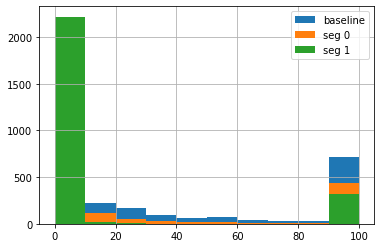

In [31]:
baseline_df.f1_seg_2.hist()
rmt_df.f1_seg_0.hist()
rmt_df.f1_seg_1.hist()
plt.legend(['baseline', 'seg 0', 'seg 1'])

In [32]:
(rmt_df.f1_seg_0 == 0).mean()

0.6988702765874562

In [33]:
(rmt_df.f1_seg_1 - rmt_df.f1_seg_0).mean()

-7.358234670821972

In [35]:
# rmt_df[rmt_df.f1_seg_1 >  0].target_text.value_counts()

In [37]:
# rmt_df[rmt_df.f1_seg_0 >  0].target_text.value_counts()

#### Valid

In [465]:
# rmt_df = pd.read_csv('tables/qasper-valid-rm-t5-1002-10.csv').sort_values(['ids']).reset_index()
rmt_df = pd.read_csv('tables/qasper-valid-rm-t5-1002-10-new.csv').sort_values(['ids']).reset_index()
rmt_df['input'] = rmt_df.ids.apply(lambda x: id2text_valid[x])

baseline_df = pd.read_csv('tables/qasper-valid-t5-base.csv').sort_values(['ids']).reset_index()
baseline_df['input'] = baseline_df.ids.apply(lambda x: id2text_valid[x])
baseline_df['f1_seg_1'] = baseline_df['f1_seg_2']

baseline_df_1024 = pd.read_csv('tables/qasper-valid-t5-base-1024.csv').sort_values(['ids']).reset_index()
baseline_df_1024['input'] = baseline_df_1024.ids.apply(lambda x: id2text_valid[x])


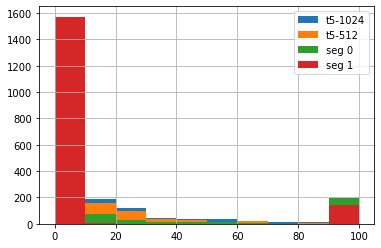

In [469]:
baseline_df_1024.f1_seg_1.hist()
baseline_df.f1_seg_1.hist()
rmt_df.f1_seg_0.hist()
rmt_df.f1_seg_1.hist()
plt.legend(['t5-1024', 't5-512', 'seg 0', 'seg 1'])

In [471]:
(rmt_df.f1_seg_0).mean(), (rmt_df.f1_seg_1).mean(), (baseline_df.f1_seg_1).mean(), (baseline_df_1024.f1_seg_1).mean()

(13.940854924681345, 8.407056431054462, 15.213263557358053, 19.504274971031283)

### baseline 1024 VS baseline 512

In [475]:
baseline_df_1024[baseline_df.f1_seg_1 < baseline_df_1024.f1_seg_1]

,index,ids,f1_seg_1,preds,preds_tokens,target_text,labels,input
2,970,003d6f9722ddc2ee13e879fefafc315fb8e87cb9,100.0000,Unanswerable,[ 0 597 3247 3321 179 1],Unanswerable,[ 597 3247 3321 179 1],What does a node in the network approach repes...
3,602,003d6f9722ddc2ee13e879fefafc315fb8e87cb9,100.0000,Unanswerable,[ 0 597 3247 3321 179 1],Unanswerable,[ 597 3247 3321 179 1],What does a node in the network approach repes...
12,353,01209a3bead7c87bcdc628be2a5a26b41abde9d1,42.1053,"SNLI BIBREF22, MultiNLI BIBREF23",[ 0 3 8544 8159 3 5972 25582 3...,"SNLI BIBREF22 and MultiNLI BIBREF23, Quora Que...",[ 3 8544 8159 3 5972 25582 371 28...,Which datasets were used?\n\nIntroduction\nIn ...
13,1104,01209a3bead7c87bcdc628be2a5a26b41abde9d1,40.0000,"SNLI BIBREF22, MultiNLI BIBREF23",[ 0 3 8544 8159 3 5972 25582 3...,"SNLI BIBREF22 and MultiNLI BIBREF23 datasets, ...",[ 3 8544 8159 3 5972 25582 371 28...,Which datasets were used?\n\nIntroduction\nIn ...
14,1286,012b8a89aea27485797373adbcda32f16f9d7b54,21.0526,Hierarchical naive Bayesian and lexicon based ...,[ 0 3204 7064 1950 3 29 9 7...,"'shallow' naive Bayes, SVM, hierarchical stack...",[ 3 31 7 107 18912 31 3 ...,What is the approach of previous work?\n\nIntr...
...,...,...,...,...,...,...,...,...
1709,886,fde700d5134a9ae8f7579bea1f1b75f34d7c1c4c,26.6667,an Android application. Each respondent instal...,[ 0 46 3054 917 5 1698 3531 295 3029 ...,Android application,[3054 917 1],how was the speech collected?\n\nIntroduction\...
1715,1353,feb448860918ef5b905bb25d7b855ba389117c1f,11.7647,635hrs of audio data for 7 Indian languages co...,[ 0 431 2469 18745 13 2931 331 ...,$\textbf {All India Radio}$ news channel,[1514 2 6327 115 89 3 2 6838 1547 ...,How was the audio data gathered?\n\nINTRODUCTI...
1719,1062,ffa7f91d6406da11ddf415ef094aaf28f3c3872d,8.6957,precision and recall of n-grams from the table...,[ 0 11723 11 7881 13 3 29 ...,Their average correlation tops the best other ...,[ 2940 1348 18712 420 7 8 200 1...,By how much more does PARENT correlate with hu...
1720,254,ffa7f91d6406da11ddf415ef094aaf28f3c3872d,10.0000,precision and recall of n-grams from the table...,[ 0 11723 11 7881 13 3 29 ...,Best proposed metric has average correlation w...,[ 1648 4382 3 7959 65 1348 18712 ...,By how much more does PARENT correlate with hu...


In [476]:
baseline_df_1024[baseline_df.f1_seg_1 > baseline_df_1024.f1_seg_1]

,index,ids,f1_seg_1,preds,preds_tokens,target_text,labels,input
15,1445,012b8a89aea27485797373adbcda32f16f9d7b54,13.8889,Hierarchical naive Bayesian and lexicon based ...,[ 0 3204 7064 1950 3 29 9 7...,BIBREF11 that uses a character level n-gram la...,[ 3 5972 25582 371 2596 24 2284 ...,What is the approach of previous work?\n\nIntr...
21,799,01f4a0a19467947a8f3bdd7ec9fac75b5222d710,0.0000,F1 score,[ 0 377 536 2604 1],INLINEFORM0 scores,[ 3388 20006 24030 632 7586 1],what were the evaluation metrics?\n\nIntroduct...
23,252,022c365a14fdec406c7a945a1a18e7e79df37f08,0.0000,MT-28K,[ 0 3 7323 18 2577 439 1],the model is pre-trained on CTC-based ASR task...,[ 8 825 19 554 18 17 10761 ...,What is the attention module pretrained on?\n\...
33,519,04bde1d2b445f971e97bb46ade2d0290981c7a32,0.0000,The meta network is used to extract the shared...,[ 0 37 10531 1229 19 261 12 58...,Unanswerable,[ 597 3247 3321 179 1],What is the meta knowledge specifically?\n\nIn...
36,630,051df74dc643498e95d16e58851701628fdfd43e,0.0000,We extracted conversation threads among users ...,[ 0 101 21527 3634 4546 7 859 11...,crawling and pre-processing an OSG web forum,[18639 53 11 554 18 15056 53 ...,How did they obtain the OSG dataset?\n\nIntrod...
...,...,...,...,...,...,...,...,...
1700,59,fd0a3e9c210163a55d3ed791e95ae3875184b8f8,0.0000,1000h of audio files,[ 0 5580 107 13 2931 2073 1],"WSJ-SI84, WSJ-SI284",[ 3 8439 683 18 134 196 4608 6 3 ...,Which dataset do they use?\n\nIntroduction\nCo...
1704,1165,fd753ab5177d7bd27db0e0afc12411876ee607df,0.0000,Unanswerable,[ 0 597 3247 3321 179 1],The baseline system for the SLC task is a very...,[ 37 20726 358 21 8 180 6480 24...,What was the baseline for this task?\n\nIntrod...
1705,392,fd753ab5177d7bd27db0e0afc12411876ee607df,0.0000,Unanswerable,[ 0 597 3247 3321 179 1],SLC task is a very simple logistic regression ...,[ 180 6480 2491 19 3 9 182 6...,What was the baseline for this task?\n\nIntrod...
1721,1228,ffde866b1203a01580eb33237a0bb9da71c75ecf,0.0000,"708 hours of French (Fr), German (De), Dutch (...",[ 0 489 4018 716 13 2379 41 3...,Unanswerable,[ 597 3247 3321 179 1],How big is Augmented LibriSpeech dataset?\n\nI...


In [472]:
rmt_df[(rmt_df.f1_seg_1 - rmt_df.f1_seg_0) > 0].preds_seg_1.value_counts()

Unanswerable                                                                                             56
FastText, LexVec, LexVec Unsupervised                                                                     3
40,000                                                                                                    1
MEDDOCAN: Medical Document Anonymization shared task dataset BIBREF3 and                                  1
a supervised learning model that can be used to train a crowd-based AI system                             1
a total of 335,698 blogs                                                                                  1
BLEU score                                                                                                1
No                                                                                                        1
a supervised learning system that automatically learns the number of answers for each visual question     1
Name: preds_seg_1, dtype: in

In [52]:
n_segments = 2
def split(text, n_segments=n_segments):
    premise = text.split('?')[0]
    encoded = tokenizer.encode(text, **encode_plus_kwargs, add_special_tokens=False)
    segments = np.split(np.array(encoded), n_segments)    
    texts = [tokenizer.decode(s) for s in segments]
    
    
    return [premise] + texts

In [53]:
max_i = 1

### analysis table

In [54]:
f1_cols = {'rm-t5-seg-2': rmt_df.f1_seg_1, 'rmt-t5-seg-1': rmt_df.f1_seg_0, 't5': baseline_df.f1_seg_1}
comp_df = pd.DataFrame(index = f1_cols.keys(), columns = f1_cols.keys())

for better_name, better_f1 in f1_cols.items():
    for worse_name, worse_f1 in f1_cols.items():
        num_occ = (better_f1 > worse_f1).sum()
        comp_df.loc[worse_name, better_name] = num_occ
        
comp_df = (comp_df / rmt_df.shape[0]).astype(float).round(2)
comp_df

,rm-t5-seg-2,rmt-t5-seg-1,t5
rm-t5-seg-2,0.00,0.18,0.42
rmt-t5-seg-1,0.04,0.00,0.35
t5,0.06,0.13,0.00


### look at texts

In [56]:
rmt_df[rmt_df.f1_seg_1 > rmt_df.f1_seg_0].preds_seg_1.value_counts() / sum(rmt_df.f1_seg_1 > rmt_df.f1_seg_0)

Unanswerable                                                                                             0.848485
FastText, LexVec, LexVec Unsupervised                                                                    0.045455
a supervised learning model that can be used to train a crowd-based AI system                            0.015152
No                                                                                                       0.015152
40,000                                                                                                   0.015152
BLEU score                                                                                               0.015152
a total of 335,698 blogs                                                                                 0.015152
MEDDOCAN: Medical Document Anonymization shared task dataset BIBREF3 and                                 0.015152
a supervised learning system that automatically learns the number of answers for each vi

In [57]:
# max_i = 10
print(f'Segment 1 better than segment 0: {sum((rmt_df.f1_seg_1 - rmt_df.f1_seg_0) > 0)}\n\n')
slice = rmt_df[(rmt_df.f1_seg_1 - rmt_df.f1_seg_0) > 0].reset_index()
for i, row in slice.iterrows():
    inp = row['input']
    spl = '\n\n'.join(split(row['input']))
    print(f"{spl}\nseg_0: {row['preds_seg_0']},\nseg_1: {row['preds_seg_1']}\ntarget: {row['target_text']}\n\n")
          
    if i > max_i:
        break

Segment 1 better than segment 0: 66


Is SemCor3.0 reflective of English language data in general

Is SemCor3.0 reflective of English language data in general? Introduction Word Sense Disambiguation (WSD) is a fundamental task and long-standing challenge in Natural Language Processing (NLP), which aims to find the exact sense of an ambiguous word in a particular context BIBREF0. Previous WSD approaches can be grouped into two main categories: knowledge-based and supervised methods. Knowledge-based WSD methods rely on lexical resources like WordNet BIBREF1 and usually exploit two kinds of lexical knowledge. The gloss, which defines a word sense meaning, is first utilized in Lesk algorithm BIBREF2 and then widely taken into account in many other approaches BIBREF3, BIBREF4. Besides, structural properties of semantic graphs are mainly used in graph-based algorithms BIBREF5, BIBREF6. Traditional supervised WSD methods BIBREF7, BIBREF8, BIBREF9 focus on extracting manually designed features

In [58]:
rmt_df[rmt_df.f1_seg_1 < rmt_df.f1_seg_0].preds_seg_0.value_counts() / sum(rmt_df.f1_seg_1 < rmt_df.f1_seg_0)

Yes                                                                                                                           0.140984
No                                                                                                                            0.127869
English                                                                                                                       0.049180
Unanswerable                                                                                                                  0.049180
LSTM-based model                                                                                                              0.016393
                                                                                                                                ...   
gendered words                                                                                                                0.003279
bifocal attention                                      

In [59]:
# max_i = 10
print(f'Segment 0 better than segment 1: {sum((rmt_df.f1_seg_1 - rmt_df.f1_seg_0) < 0)}\n\n')
slice = rmt_df[(rmt_df.f1_seg_1 - rmt_df.f1_seg_0) < 0].reset_index()
for i, row in slice.iterrows():
    inp = row['input']
    spl = '\n\n'.join(split(row['input']))
    print(f"{spl}\nseg_0: {row['preds_seg_0']},\nseg_1: {row['preds_seg_1']}\ntarget: {row['target_text']}\n\n")
          
    if i > max_i:
        break

Segment 0 better than segment 1: 305


How do they split text to obtain sentence levels

How do they split text to obtain sentence levels? Introduction Many machine learning models in question answering tasks often involve matching mechanism. For example, in factoid question answering such as SQuAD BIBREF1, one needs to match between query and corpus in order to find out the most possible fragment as answer. In multiple choice question answering, such as MC Test BIBREF2, matching mechanism can also help make the correct decision. The easiest way of matching is to calculate the cosine similarity between two vectors. It is generally done by two step: First, encode text into word vectors, sentence vectors or paragraph vectors. Second, simply calculate the cosine similarity between target vectors. This method performs well when applied to word-level matching. However, as for matching between sentences or paragraphs, a single vector is not sufficient to encode all the important information.

In [60]:
# rmt_df[baseline_df.f1_seg_1 > rmt_df.f1_seg_0].preds_seg_1.value_counts() / sum(baseline_df.f1_seg_1 > rmt_df.f1_seg_0)
baseline_df[baseline_df.f1_seg_1 > rmt_df.f1_seg_1].preds.value_counts() / sum(baseline_df.f1_seg_1 > rmt_df.f1_seg_1)

Yes                                                                                               0.071031
No                                                                                                0.062674
Unanswerable                                                                                      0.019499
English                                                                                           0.015320
profanity, insult, and abuse                                                                      0.005571
                                                                                                    ...   
Annotation of a target with or without affiliation to a political party                           0.001393
BiLSTM+CNN+CRF, Stanford CRF, BiLSTM+C                                                            0.001393
probes from BIBREF1                                                                               0.001393
using the BLEU scale                 

In [61]:
# max_i = 10
mask = (rmt_df.f1_seg_0 - baseline_df.f1_seg_1) > 0
print(f'Segment 0 better than baseline: {sum(mask)}\n\n')
slice = rmt_df[mask].reset_index()
slice_bl = baseline_df[mask].reset_index()
for i, row in slice.iterrows():
    inp = row['input']
    spl = '\n\n'.join(split(row['input']))
    # bl_pred = baseline_df[baseline_df.ids == row['ids']].preds.iloc[0]
    bl_pred = slice_bl.iloc[i].preds
    # print(slice.iloc[i])
    # print(slice_bl.iloc[i])
    print(f"{spl}\nseg_0: {row['preds_seg_0']},\nseg_1: {row['preds_seg_1']}\nbaseline: {bl_pred}\ntarget: {row['target_text']}\n\n")
          
    if i > max_i:
        break

Segment 0 better than baseline: 223


How do they split text to obtain sentence levels

How do they split text to obtain sentence levels? Introduction Many machine learning models in question answering tasks often involve matching mechanism. For example, in factoid question answering such as SQuAD BIBREF1, one needs to match between query and corpus in order to find out the most possible fragment as answer. In multiple choice question answering, such as MC Test BIBREF2, matching mechanism can also help make the correct decision. The easiest way of matching is to calculate the cosine similarity between two vectors. It is generally done by two step: First, encode text into word vectors, sentence vectors or paragraph vectors. Second, simply calculate the cosine similarity between target vectors. This method performs well when applied to word-level matching. However, as for matching between sentences or paragraphs, a single vector is not sufficient to encode all the important information. 

In [63]:
max_i = 1
mask = (rmt_df.f1_seg_0 - baseline_df.f1_seg_1) < 0
print(f'Segment 0 worse than baseline: {sum(mask)}\n\n')
slice = rmt_df[mask].reset_index()
for i, row in slice.iterrows():
    inp = row['input']
    spl = '\n\n'.join(split(row['input']))
    bl_pred = baseline_df[baseline_df.ids == row['ids']].preds.iloc[0]
    # bl_pred = baseline_df[baseline_df.ids == row['ids']].preds
    print(f"{spl}\nseg_0: {row['preds_seg_0']},\nseg_1: {row['preds_seg_1']}\nbaseline: {bl_pred}\ntarget: {row['target_text']}\n\n")
          
    if i > max_i:
        break

Segment 0 worse than baseline: 610


Is SemCor3.0 reflective of English language data in general

Is SemCor3.0 reflective of English language data in general? Introduction Word Sense Disambiguation (WSD) is a fundamental task and long-standing challenge in Natural Language Processing (NLP), which aims to find the exact sense of an ambiguous word in a particular context BIBREF0. Previous WSD approaches can be grouped into two main categories: knowledge-based and supervised methods. Knowledge-based WSD methods rely on lexical resources like WordNet BIBREF1 and usually exploit two kinds of lexical knowledge. The gloss, which defines a word sense meaning, is first utilized in Lesk algorithm BIBREF2 and then widely taken into account in many other approaches BIBREF3, BIBREF4. Besides, structural properties of semantic graphs are mainly used in graph-based algorithms BIBREF5, BIBREF6. Traditional supervised WSD methods BIBREF7, BIBREF8, BIBREF9 focus on extracting manually designed features 

In [64]:
max_i = 1
mask = (rmt_df.f1_seg_1 - baseline_df.f1_seg_1) > 0
print(f'Segment 1 better than baseline: {sum(mask)}\n\n')
slice = rmt_df[mask].reset_index()
for i, row in slice.iterrows():
    inp = row['input']
    spl = '\n\n'.join(split(row['input']))
    bl_pred = baseline_df[baseline_df.ids == row['ids']].preds.iloc[0]
    print(f"{spl}\nseg_0: {row['preds_seg_0']},\nseg_1: {row['preds_seg_1']}\nbaseline: {bl_pred}\ntarget: {row['target_text']}\n\n")
          
    if i > max_i:
        break

Segment 1 better than baseline: 101


Is SemCor3.0 reflective of English language data in general

Is SemCor3.0 reflective of English language data in general? Introduction Word Sense Disambiguation (WSD) is a fundamental task and long-standing challenge in Natural Language Processing (NLP), which aims to find the exact sense of an ambiguous word in a particular context BIBREF0. Previous WSD approaches can be grouped into two main categories: knowledge-based and supervised methods. Knowledge-based WSD methods rely on lexical resources like WordNet BIBREF1 and usually exploit two kinds of lexical knowledge. The gloss, which defines a word sense meaning, is first utilized in Lesk algorithm BIBREF2 and then widely taken into account in many other approaches BIBREF3, BIBREF4. Besides, structural properties of semantic graphs are mainly used in graph-based algorithms BIBREF5, BIBREF6. Traditional supervised WSD methods BIBREF7, BIBREF8, BIBREF9 focus on extracting manually designed features

In [67]:
rmt_df[mask].target_text.value_counts() / sum(mask)

Unanswerable                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              0.861386
Yes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  